# Analysis and Classification of Stack Overflow Questions

### The goal of this project is to classify questions retrieved from the Stack Overflow database available on BigQuery based on the programming languages they are related to. We analyzed about 7500 records in order to understand how to leverage the attributes in the stack overflow database to accurately classify the questions into five different programming languages (android, java, javascript, asp.net, ruby). 

In [1]:
#!pip install google-cloud-bigquery
#!pip install wordcloud

In [3]:
# Import packages
import os
from google.cloud import bigquery
from wordcloud import WordCloud 
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Connecting to BigQuery and querying Stack Overflow data

In [4]:
# Here, replace json file with the new downloaded json file. Refer Readme document.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/Users/sneha/Documents/Sem3/Python/Python Project/My First Project-a1d746fe13ab.json'

In [7]:
client = bigquery.Client()
dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")
# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

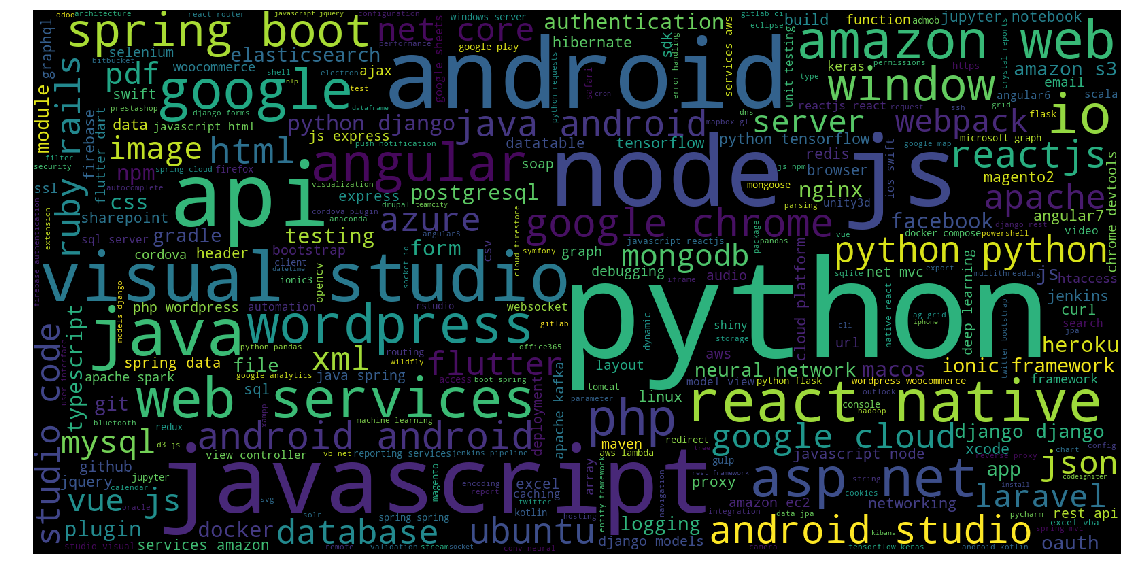

In [8]:
#This query is written to make a word cloud to see the most
#popular tags. We chose the five languages for classification from 
# the word cloud itself.
query4 = """SELECT tags
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 7500;
"""

#Convert to dataframe for visualization purpose
alltags=client.query(query4)
e_df=alltags.to_dataframe()
e_df

#Create word cloud
tags = ' '.join(e_df.tags).lower()
cloud = WordCloud(background_color='black',
                            max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=300,
                            relative_scaling=.5).generate(tags)
# Display Word Cloud
plt.figure(figsize=(20,10))
plt.axis('off')
plt.savefig('stackOverflow.png')
plt.imshow(cloud);

In [9]:
# Retreiving data from database using SQL. The query ensures that the retrieved data is tagged as 
# either a android, java, javascript, ruby, or asp.net based question. 
# Also, length of the body was limited to only 1000 characters in length, and only 7500 results were retreived. 
# These constraints were placed in order to prevent memory overflow.
query1="""
         SELECT
             title,
             body as question,
             tags as labels, 
             view_count as views
         FROM
             `bigquery-public-data.stackoverflow.posts_questions`
         WHERE 
             (tags LIKE '%android%' OR
             tags LIKE '%asp%net%' OR 
             tags LIKE '%javascript%' OR 
             tags LIKE '%ruby%' OR
             tags LIKE '%java%') AND
             LENGTH(body) < 1000
             LIMIT 7500;
         """

# Convert retrieved data to dataframe
query_job=client.query(query1)
questions_df=query_job.to_dataframe()

# Display dataframe
questions_df

,title,question,labels,views
0,ActiveRecord query to sum nested object values...,<p>I have a model named <code>Appointment</cod...,sql|ruby-on-rails|ruby-on-rails-3|activerecord,256
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",java|google-app-engine|mapreduce,256
2,JAVA Cant find subclass method via cast,<p>I have this problem with my homework and I ...,java|inheritance|casting|subclass|superclass,256
3,How to get user current location WOEID,<p>I'm currently working on a project that mak...,javascript|jquery|location,256
4,SignalR custom server side methods,<p>Some time ago I had the question why client...,javascript|asp.net|signalr,256
5,Can't able to open collabnet merge wizard in e...,"<p>I had installed ""Collabnet Merge Client"" in...",android|merge|client|collabnet,512
6,How to add HTML text in ajax editor control us...,<p>I'm using asp.net AJAX controls. I have add...,asp.net|ajax|c#-4.0,512
7,How do you connect postgres to heroku through ...,<p>Hi I've been researching on how to use hero...,java|eclipse|postgresql|heroku|pgadmin,512
8,"Create a ""Did You Mean...?"" type of search in ...","<p>So, I have a website with a search bar.</p>...",asp.net|vb.net|search,512
9,comparing image from ui to saved image in SQL ...,<p>I had developed an application in Asp.Net w...,c#|asp.net|sql-server|image,512


### 2. Data Preprocessing


In [10]:
#Setting the grid style to whitegrid
sns.set_style('whitegrid')


In [11]:
# We observe that tags are seperated by "|". We split the tags accordingly
questions_df['labels'] = questions_df['labels'].str.split('|')

In [12]:
questions_df.head(2)

,title,question,labels,views
0,ActiveRecord query to sum nested object values...,<p>I have a model named <code>Appointment</cod...,"[sql, ruby-on-rails, ruby-on-rails-3, activere...",256
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...","[java, google-app-engine, mapreduce]",256


In [13]:
# we find the programming language tags and limit the questions to only those involving a single programming langauge.
# We write a function to do so. 
def return_tags(labels):
    langauges = [lang for lang in labels if lang in ['android','asp.net','ruby','java','javascript']] 
    return langauges 


In [14]:
# Apply the function to labels column of our dataframe.
questions_df['labels'] = questions_df['labels'].apply(return_tags)

In [15]:
# Display dataframe to make sure our function was applied successfully.
questions_df.head(2)

,title,question,labels,views
0,ActiveRecord query to sum nested object values...,<p>I have a model named <code>Appointment</cod...,[],256
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",[java],256


In [16]:
# Find rows that contain only a single tag. For that we check the length of the
# labels column and filter out data accordingly.
df = questions_df[(questions_df['labels'].apply(len) > 0) & (questions_df['labels'].apply(len) < 2)] 

In [17]:
# Display dataframe to see if the function worked properly.
df.head(2)

,title,question,labels,views
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",[java],256
2,JAVA Cant find subclass method via cast,<p>I have this problem with my homework and I ...,[java],256


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6082 entries, 1 to 7499
Data columns (total 4 columns):
title       6082 non-null object
question    6082 non-null object
labels      6082 non-null object
views       6082 non-null int64
dtypes: int64(1), object(3)
memory usage: 237.6+ KB


In [19]:
# Covert labels from lists to string.
def lst_to_str(lst):
    unpacked = ''.join(lst)
    return unpacked

df.loc[:,'labels'] = df.loc[:,'labels'].apply(lst_to_str)

C:\Users\sneha\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
#df.groupby('labels').describe()
df.head(2)

,title,question,labels,views
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",java,256
2,JAVA Cant find subclass method via cast,<p>I have this problem with my homework and I ...,java,256


### 3. Feature Engineering and Exploratory Data Analysis

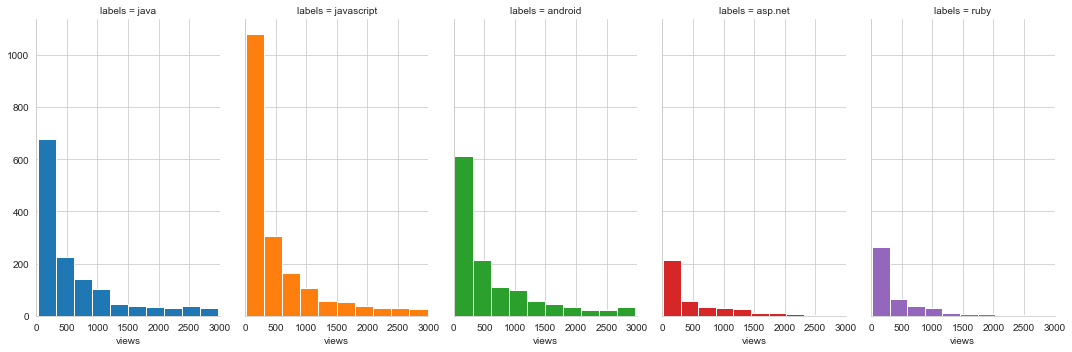

In [21]:
# In grid_1, we explore the distribution of the number of view each question got based on what 
# language they were related to.
grid_1 = sns.FacetGrid(df[df['views'] < 3000], col = 'labels', height = 5, aspect = 0.6, hue = 'labels')
grid_1.map(plt.hist, 'views', bins = 10)
axes = grid_1.axes
axes[0,1].set_xlim([0,3000])

plt.tight_layout()

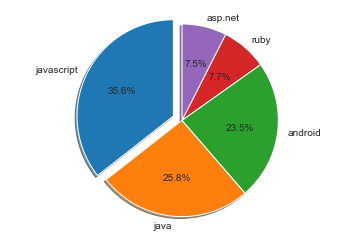

In [22]:
# Create a pie chart to see percentage of each tag in our dataset.
temp = df['labels'].value_counts()
temp

df_temp = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

explode = (0.1, 0, 0, 0, 0)
type(df_temp) 

fig1, ax1 = plt.subplots()
ax1.pie(df_temp['values'], labels=df_temp['labels'], autopct='%1.1f%%',
        shadow=True, startangle=90, explode = explode)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display Pie Chart
plt.show()

In [23]:
# To analyze the length of question, we apply length function to questions column, 
# and place the results in a new column named - "Length of Question"
df.loc[:,'Length of Question'] = df.loc[:,'question'].apply(len)

C:\Users\sneha\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [24]:
# Display dataframe to check the new column
# Verify if the procedure
df.head(2)

,title,question,labels,views,Length of Question
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",java,256,398
2,JAVA Cant find subclass method via cast,<p>I have this problem with my homework and I ...,java,256,857


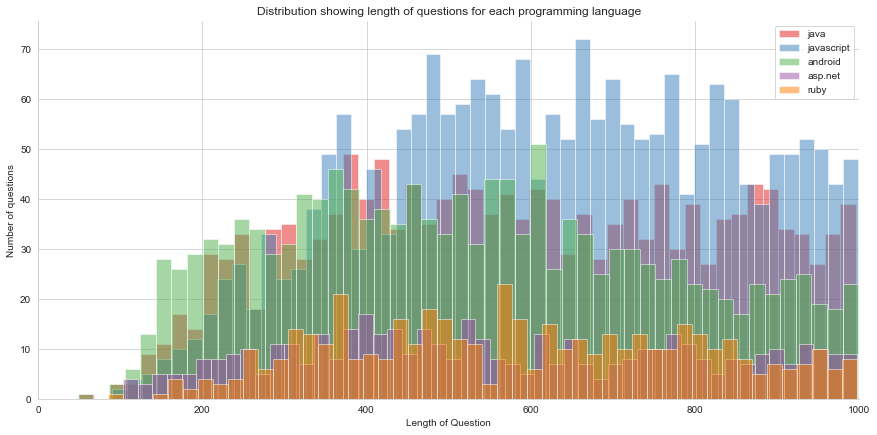

In [25]:
# Plot the length of each question based on what language they were written in
# Create a palette for better visualization
Set1 = sns.diverging_palette(150, 275, s=80, l=55, n=9)
grid_2 = sns.FacetGrid(df, hue = 'labels' ,palette = "Set1" ,height = 6, aspect = 2)
grid_2.map(plt.hist, 'Length of Question', bins = 50, alpha = 0.5)
axes = grid_2.axes

axes[0,0].set_ylabel('Number of questions')
axes[0,0].set_title('Distribution showing length of questions for each programming language')
axes[0,0].set_xlim([0,1000])
axes[0,0].legend()

In [26]:
# We need to use html parser to retrieve the code from the questions. To do so, we define function
# that extracts code from the question. The function returns the extracted code.
import lxml.html

def find_final_code(string_html):
    final = []

    d = lxml.html.fromstring(string_html) 
    codes = d.xpath('//code')

    for code in codes:
        if code.text is None: 
            final.append('')
        else:
            final.append(code.text)
        
        
    final = ' '.join(final)
    return final

In [27]:
# Apply the html parser function to the questions column and store the result in a new 
# column named "code". 
df.loc[:,'code'] = df.loc[:,'question'].apply(find_final_code)

# Display the dataframe to verify the function.
df.head(5)

,title,question,labels,views,Length of Question,code
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",java,256,398,
2,JAVA Cant find subclass method via cast,<p>I have this problem with my homework and I ...,java,256,857,public class A{...}\n\npublic class B extends ...
3,How to get user current location WOEID,<p>I'm currently working on a project that mak...,javascript,256,450,
5,Can't able to open collabnet merge wizard in e...,"<p>I had installed ""Collabnet Merge Client"" in...",android,512,443,"How to open ""Collabnet Merge Client"" wizard"
6,How to add HTML text in ajax editor control us...,<p>I'm using asp.net AJAX controls. I have add...,asp.net,512,307,


In [28]:
# Functions that will extract features from the code. These functions are applied to the newly created
# code column. The functions defined below extract features and return count of that feature.
def count_of_colons(txt):
    return txt.count(':')

def count_of_semicolons(txt):
    return txt.count(';')

def count_of_slashes(txt):
    return txt.count('/')
                                      
def count_of_cbrackets(txt):
    return txt.count('{') + txt.count('}')

def count_of_sbrackets(txt):
    return txt.count('[') + txt.count(']')

def count_of_quotes(txt):
    return txt.count('"') + txt.count("'")

def count_of_arithmetic(txt):
    return txt.count('<') + txt.count('>') + txt.count('-') + txt.count('+') 

def count_of_period(txt):
    return txt.count('.')

In [29]:
df.loc[:,'colon count']     = df.loc[:,'code'].apply(count_of_colons)
df.loc[:,'semicolon count'] = df.loc[:,'code'].apply(count_of_semicolons)
df.loc[:,'slash count']     = df.loc[:,'code'].apply(count_of_slashes)
df.loc[:,'cbracket count']  = df.loc[:,'code'].apply(count_of_cbrackets)
df.loc[:,'sbracket count']  = df.loc[:,'code'].apply(count_of_sbrackets)
df.loc[:,'quote count']     = df.loc[:,'code'].apply(count_of_quotes)
df.loc[:,'operator count']  = df.loc[:,'code'].apply(count_of_arithmetic)
df.loc[:,'period count']    = df.loc[:,'code'].apply(count_of_period)

In [30]:
# Display the dataframe to verify that function worked.
df.head(5)

,title,question,labels,views,Length of Question,code,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",java,256,398,,0,0,0,0,0,0,0,0
2,JAVA Cant find subclass method via cast,<p>I have this problem with my homework and I ...,java,256,857,public class A{...}\n\npublic class B extends ...,0,1,0,12,0,0,0,10
3,How to get user current location WOEID,<p>I'm currently working on a project that mak...,javascript,256,450,,0,0,0,0,0,0,0,0
5,Can't able to open collabnet merge wizard in e...,"<p>I had installed ""Collabnet Merge Client"" in...",android,512,443,"How to open ""Collabnet Merge Client"" wizard",0,0,0,0,0,2,0,0
6,How to add HTML text in ajax editor control us...,<p>I'm using asp.net AJAX controls. I have add...,asp.net,512,307,,0,0,0,0,0,0,0,0


Text(0.5,1,'Syntactic Features')

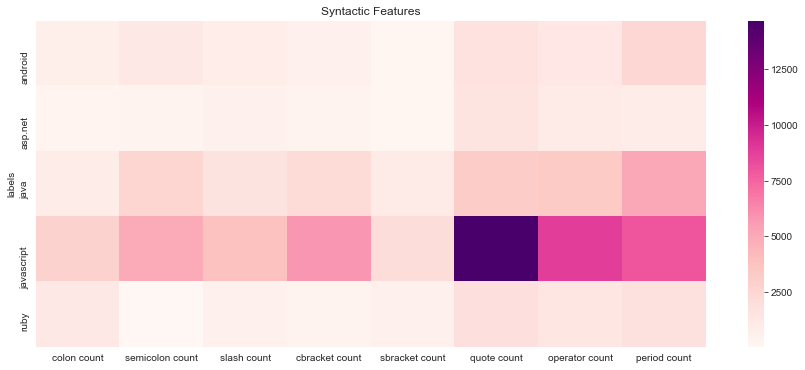

In [31]:
# After it is verified that the function has worked, here is a heatmap displaying the total of the syntactic features grouped by their language.
syntaxfeatures = df.groupby('labels').sum(axis=1).loc[:,'colon count':]

fig, aggregate_axis = plt.subplots(figsize=(15,6))
sns.heatmap(syntaxfeatures, cmap = 'RdPu', ax = aggregate_axis)
aggregate_axis.set_title('Syntactic Features')

In [32]:
syntaxfeatures.head(2)

,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
labels,,,,,,,,
android,720,1291,837,660,228,1738,1338,2533
asp.net,288,412,521,336,204,1538,1085,921


In [33]:
#Since the entire data was not considered for this project, the above heatmap is skewed. 
#To remove the effects of uneven SQL query retrieval, we have scaled the syntactic features using MinMaxSaclar()
#provided by Scikit Learn.
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
syntaxfeatures_scaled= pd.DataFrame(mmscaler.fit_transform(syntaxfeatures.T), columns = syntaxfeatures.index, index = syntaxfeatures.columns)
syntaxfeatures_scaled.head(10)



C:\Users\sneha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


labels,android,asp.net,java,javascript,ruby
colon count,0.213449,0.062969,0.000000,0.054711,0.647721
semicolon count,0.461171,0.155922,0.406394,0.226248,0.000000
slash count,0.264208,0.237631,0.174376,0.134347,0.327078
cbracket count,0.187419,0.098951,0.310002,0.296329,0.212869
sbracket count,0.000000,0.000000,0.005570,0.000000,0.311528
quote count,0.655098,1.000000,0.546864,1.000000,1.000000
operator count,0.481562,0.660420,0.569629,0.539380,0.723861
period count,1.000000,0.537481,1.000000,0.467070,0.923324


Text(0.5,1,'Normalized Code Features')

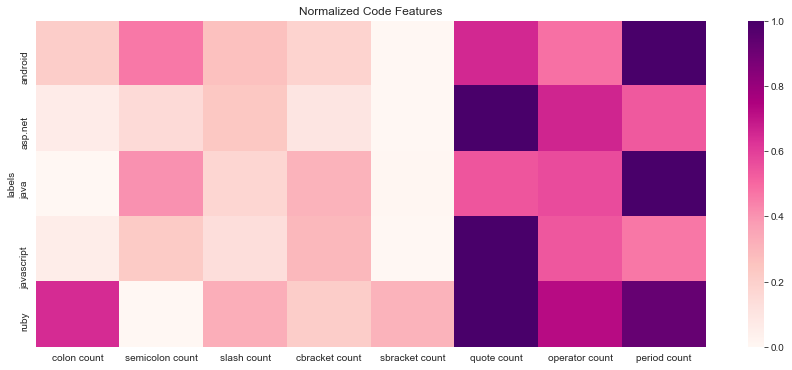

In [34]:
#Heatmap with normalised snytactic features grouped by the language.
fig, axis_scaled = plt.subplots(figsize=(15,6))
sns.heatmap(syntaxfeatures_scaled.T, cmap = 'RdPu', ax = axis_scaled)
axis_scaled.set_title('Normalized Code Features')

#### Finding features from Content in Question and Title columns

In [35]:
#Function to parse the actual content of questions column which contains the question description as well as the code.
from bs4 import BeautifulSoup

def find_text(html_str):
    full_text = ''

    parsedContent = BeautifulSoup(html_str, 'html.parser')

    text = parsedContent.findAll('p')
    
    for paragraph in text:
        full_text = full_text + paragraph.getText()
        
    return full_text

In [36]:
#Function to remove stopwords and punctuations
import re 
import string
from nltk.corpus import stopwords 

stop_words = stopwords.words() 
translation_table = dict.fromkeys(map(ord, string.punctuation), None)

def remove_punc_and_stopwords(full_text):
    cleaned_text = full_text.translate(translation_table)
    word_lst = re.findall('[a-zA-Z]+', cleaned_text)
    return " ".join(word_lst)

In [37]:
def clean_html_text(text):
    final_text = find_text(text)
    bag_of_words = remove_punc_and_stopwords(final_text)
    return bag_of_words

In [38]:
df.head(2)

,title,question,labels,views,Length of Question,code,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
1,Mapreduce - sequence jobs?,"<p>I am using MapReduce (just map, really) to ...",java,256,398,,0,0,0,0,0,0,0,0
2,JAVA Cant find subclass method via cast,<p>I have this problem with my homework and I ...,java,256,857,public class A{...}\n\npublic class B extends ...,0,1,0,12,0,0,0,10


In [39]:
#The actual contents of title and question columns are parsed with stopwords and punctuations removed. 
df.loc[:,'title'] = df.loc[:,'title'].apply(remove_punc_and_stopwords)
df.loc[:,'question'] = df.loc[:,'question'].apply(clean_html_text)
df.head(10)

C:\Users\sneha\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,title,question,labels,views,Length of Question,code,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
1,Mapreduce sequence jobs,I am using MapReduce just map really to do a d...,java,256,398,,0,0,0,0,0,0,0,0
2,JAVA Cant find subclass method via cast,I have this problem with my homework and I can...,java,256,857,public class A{...}\n\npublic class B extends ...,0,1,0,12,0,0,0,10
3,How to get user current location WOEID,Im currently working on a project that makes u...,javascript,256,450,,0,0,0,0,0,0,0,0
5,Cant able to open collabnet merge wizard in ec...,I had installed Collabnet Merge Client in ecli...,android,512,443,"How to open ""Collabnet Merge Client"" wizard",0,0,0,0,0,2,0,0
6,How to add HTML text in ajax editor control us...,Im using aspnet AJAX controls I have added an ...,asp.net,512,307,,0,0,0,0,0,0,0,0
7,How do you connect postgres to heroku through ...,Hi Ive been researching on how to use heroku w...,java,512,929,,0,0,0,0,0,0,0,0
8,Create a Did You Mean type of search in ASPNET...,So I have a website with a search barI have on...,asp.net,512,403,,0,0,0,0,0,0,0,0
9,comparing image from ui to saved image in SQL ...,I had developed an application in AspNet which...,asp.net,512,354,,0,0,0,0,0,0,0,0
15,Angular NgRepeat with Key Value list,I am returning an object that contains keyvalu...,javascript,1536,541,"ng-repeat=""(index, thing) in data""\n ng-repeat...",1,0,0,0,0,4,2,0
16,how to create a time change listener,I have an application that will create a persi...,android,1792,557,,0,0,0,0,0,0,0,0


In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [41]:
#Using CountVectorizer, the text of title and question columns is converted into a "bag-of-words". 
#Further, using tf-idf the weights have been scaled according to how relevant each word is to the dataset.
#The results are stored in new dataframes to be concatenated with the rest of the neural network inputs later on.
cv_title = CountVectorizer().fit(df['title'])
vectorized_title = cv_title.transform(df['title'])
vectorized_title_df = pd.DataFrame(vectorized_title.toarray(), columns = cv_title.get_feature_names())

# implement tfidf
tfidf_title = TfidfTransformer().fit(vectorized_title)
vectorized_tfidf_title = tfidf_title.transform(vectorized_title)
vectorized_tfidf_title_df = pd.DataFrame(vectorized_tfidf_title.toarray(), columns = cv_title.get_feature_names())

cv_question = CountVectorizer().fit(df['question'])
vectorized_question = cv_question.transform(df['question'])
vectorized_question_df = pd.DataFrame(vectorized_question.toarray(), columns = cv_question.get_feature_names())

# implement tfidf
tfidf_question = TfidfTransformer().fit(vectorized_question)
vectorized_tfidf_question = tfidf_question.transform(vectorized_question)
vectorized_tfidf_question_df = pd.DataFrame(vectorized_tfidf_question.toarray(), columns = cv_question.get_feature_names())

# combine dataframes 
cv_bow = pd.concat([vectorized_title_df, vectorized_question_df], axis = 1)
cv_tfidf_bow = pd.concat([vectorized_tfidf_title_df, vectorized_tfidf_question_df], axis = 1)

In [42]:
vectorized_title_df.head(5)

,ab,abi,able,abnormal,aborts,about,above,abr,abs,absolut,...,zipcode,zkoss,zone,zookeeper,zoom,zoomable,zooming,zoomout,zooms,zxing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
#Since the values in views and lenth of question columns are far greater than the values in columns of syntactic 
#and code features, we have scaled these columns as well.
views_and_length = df.loc[:,['views','Length of Question']]
code_features = df.loc[:,'colon count':]

# Scale the views column
ss_view_length = StandardScaler()
scaled_views_and_length = ss_view_length.fit_transform(views_and_length.astype(float)) 
scaled_views_and_length_df = pd.DataFrame(scaled_views_and_length, columns = views_and_length.columns)

# Scale the code features
ss_code = StandardScaler()
scaled_code_features = ss_code.fit_transform(code_features.astype(float))
scaled_code_features_df = pd.DataFrame(scaled_code_features, columns = code_features.columns)

# Concatenate the results into complete preprocessed dataframe.
final_scaled_vectorized_df = pd.concat([vectorized_title_df, vectorized_question_df, scaled_views_and_length_df, scaled_code_features_df], axis = 1)
final_scaled_vectorized_df.head(2)

,ab,abi,able,abnormal,aborts,about,above,abr,abs,absolut,...,views,Length of Question,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
0,0,0,0,0,0,0,0,0,0,0,...,-0.200836,-0.807970,-0.393986,-0.559717,-0.431429,-0.497926,-0.256951,-0.538937,-0.389792,-0.611546
1,0,0,0,0,0,0,0,0,0,0,...,-0.200836,1.196138,-0.393986,-0.194890,-0.431429,3.326196,-0.256951,-0.538937,-0.389792,1.423260


In [45]:
final_scaled_vectorized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6082 entries, 0 to 6081
Columns: 30818 entries, ab to period count
dtypes: float64(10), int64(30808)
memory usage: 1.4 GB


## 4. Predictive Analytics

### Deep Learning Model

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

#This is a sequential model having 5 dense layers. The activation function for hidden layers is ReLU.
classifier = Sequential()
classifier.add(Dense(6000,
                     input_shape = (28723,),
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )  
#Adding dropout to avoid overfitting
classifier.add(Dropout(0.35))
classifier.add(Dense(2000,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
classifier.add(Dropout(0.25))
classifier.add(Dense(500,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
classifier.add(Dropout(0.25))
classifier.add(Dense(50,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
#Since, this is a multiclass classification problem, the output activation function is Sigmoid.
classifier.add(Dense(5,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'softmax'
                    )
              )
#Optimizer Adam was chosen so that the learning rate for the parameters could be adjusted.
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Using TensorFlow backend.


In [47]:
#splitting the data into 70% train and 30% test data
from sklearn.model_selection import train_test_split

X = final_scaled_vectorized_df
y = pd.get_dummies(df['labels'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [52]:
#Fit the train data to the model
classifier.fit(X_train, y_train, batch_size = 256, epochs = 75)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/75
4087/4087 [==============================] - ETA: 5:12 - loss: 1.5916 - acc: 0.328 - ETA: 2:56 - loss: 1.7456 - acc: 0.322 - ETA: 2:05 - loss: 1.7056 - acc: 0.317 - ETA: 1:38 - loss: 1.6585 - acc: 0.332 - ETA: 1:18 - loss: 1.6183 - acc: 0.345 - ETA: 1:04 - loss: 1.5995 - acc: 0.345 - ETA: 53s - loss: 1.5822 - acc: 0.356 - ETA: 44s - loss: 1.5620 - acc: 0.36 - ETA: 37s - loss: 1.5425 - acc: 0.37 - ETA: 31s - loss: 1.5260 - acc: 0.37 - ETA: 25s - loss: 1.5006 - acc: 0.39 - ETA: 19s - loss: 1.4714 - acc: 0.40 - ETA: 14s - loss: 1.4483 - acc: 0.41 - ETA: 9s - loss: 1.4201 - acc: 0.4244 - ETA: 4s - loss: 1.3895 - acc: 0.440 - 72s 18ms/step - loss: 1.3657 - acc: 0.4517
Epoch 2/75
4087/4087 [==============================] - ETA: 45s - loss: 0.7573 - acc: 0.70 - ETA: 40s - loss: 0.7067 - acc: 0.74 - ETA: 41s - loss: 0.6739 - acc: 0.74 - ETA: 36s - loss: 0.6511 - acc: 0.74 - ETA: 35s - loss

4087/4087 [==============================] - ETA: 56s - loss: 2.5305e-05 - acc: 1.00 - ETA: 52s - loss: 1.7455e-05 - acc: 1.00 - ETA: 48s - loss: 1.6657e-05 - acc: 1.00 - ETA: 45s - loss: 1.8365e-05 - acc: 1.00 - ETA: 41s - loss: 1.7784e-05 - acc: 1.00 - ETA: 37s - loss: 1.9974e-05 - acc: 1.00 - ETA: 34s - loss: 1.9947e-05 - acc: 1.00 - ETA: 30s - loss: 1.9361e-05 - acc: 1.00 - ETA: 26s - loss: 1.9286e-05 - acc: 1.00 - ETA: 22s - loss: 1.8811e-05 - acc: 1.00 - ETA: 18s - loss: 1.8432e-05 - acc: 1.00 - ETA: 14s - loss: 1.7661e-05 - acc: 1.00 - ETA: 11s - loss: 1.7404e-05 - acc: 1.00 - ETA: 7s - loss: 1.6957e-05 - acc: 1.0000 - ETA: 3s - loss: 2.4455e-05 - acc: 1.000 - 60s 15ms/step - loss: 2.3852e-05 - acc: 1.0000
Epoch 24/75
4087/4087 [==============================] - ETA: 1:01 - loss: 2.2244e-05 - acc: 1.000 - ETA: 56s - loss: 2.2485e-05 - acc: 1.000 - ETA: 52s - loss: 2.1669e-05 - acc: 1.00 - ETA: 47s - loss: 2.0343e-05 - acc: 1.00 - ETA: 41s - loss: 1.9137e-05 - acc: 1.00 - ETA: 37

4087/4087 [==============================] - ETA: 46s - loss: 3.6883e-06 - acc: 1.00 - ETA: 46s - loss: 3.0929e-06 - acc: 1.00 - ETA: 43s - loss: 3.7685e-06 - acc: 1.00 - ETA: 40s - loss: 4.5704e-06 - acc: 1.00 - ETA: 37s - loss: 4.6927e-06 - acc: 1.00 - ETA: 34s - loss: 4.6213e-06 - acc: 1.00 - ETA: 31s - loss: 4.2759e-06 - acc: 1.00 - ETA: 27s - loss: 5.1823e-06 - acc: 1.00 - ETA: 24s - loss: 5.4435e-06 - acc: 1.00 - ETA: 21s - loss: 5.2821e-06 - acc: 1.00 - ETA: 17s - loss: 5.0354e-06 - acc: 1.00 - ETA: 14s - loss: 4.8851e-06 - acc: 1.00 - ETA: 10s - loss: 4.7934e-06 - acc: 1.00 - ETA: 7s - loss: 4.7235e-06 - acc: 1.0000 - ETA: 3s - loss: 4.6582e-06 - acc: 1.000 - 57s 14ms/step - loss: 4.5173e-06 - acc: 1.0000
Epoch 46/75
4087/4087 [==============================] - ETA: 55s - loss: 7.8611e-06 - acc: 1.00 - ETA: 55s - loss: 5.5396e-06 - acc: 1.00 - ETA: 50s - loss: 4.2991e-06 - acc: 1.00 - ETA: 46s - loss: 4.1693e-06 - acc: 1.00 - ETA: 42s - loss: 3.8391e-06 - acc: 1.00 - ETA: 38s -

4087/4087 [==============================] - ETA: 58s - loss: 2.0115e-06 - acc: 1.00 - ETA: 53s - loss: 2.2175e-06 - acc: 1.00 - ETA: 48s - loss: 1.9159e-06 - acc: 1.00 - ETA: 44s - loss: 1.9644e-06 - acc: 1.00 - ETA: 40s - loss: 2.0123e-06 - acc: 1.00 - ETA: 37s - loss: 2.2809e-06 - acc: 1.00 - ETA: 33s - loss: 2.1932e-06 - acc: 1.00 - ETA: 29s - loss: 2.0762e-06 - acc: 1.00 - ETA: 26s - loss: 2.0860e-06 - acc: 1.00 - ETA: 22s - loss: 3.1853e-06 - acc: 1.00 - ETA: 18s - loss: 3.4366e-06 - acc: 1.00 - ETA: 15s - loss: 3.4322e-06 - acc: 1.00 - ETA: 11s - loss: 3.3110e-06 - acc: 1.00 - ETA: 7s - loss: 3.1900e-06 - acc: 1.0000 - ETA: 3s - loss: 3.1587e-06 - acc: 1.000 - 60s 15ms/step - loss: 4.0266e-06 - acc: 1.0000
Epoch 68/75
4087/4087 [==============================] - ETA: 56s - loss: 2.2001e-06 - acc: 1.00 - ETA: 54s - loss: 2.1274e-06 - acc: 1.00 - ETA: 50s - loss: 2.4773e-06 - acc: 1.00 - ETA: 47s - loss: 2.2200e-06 - acc: 1.00 - ETA: 43s - loss: 2.7736e-06 - acc: 1.00 - ETA: 38s -

In [53]:
#Predictions using deep learning
predictions = classifier.predict(X_test)
predictions

array([[3.33534932e-04, 1.12097887e-08, 9.99666333e-01, 1.07224674e-10,
        1.28296946e-07],
       [1.00000000e+00, 1.12055739e-31, 2.76826084e-22, 2.06315534e-28,
        1.35949861e-33],
       [9.99996424e-01, 6.64601318e-10, 3.60106628e-06, 8.30822611e-09,
        2.84112023e-09],
       ...,
       [5.57961926e-07, 2.46472831e-04, 5.85476450e-08, 9.99750435e-01,
        2.58962586e-06],
       [3.93464916e-06, 1.69634279e-02, 9.83032346e-01, 1.98183283e-08,
        3.43224997e-07],
       [2.41816150e-14, 2.04244022e-12, 1.38541566e-15, 1.00000000e+00,
        6.07222952e-12]], dtype=float32)

In [54]:
from sklearn.preprocessing import LabelBinarizer

labels = np.argmax(predictions, axis = 1)
lb = LabelBinarizer()
labeled_predictions = lb.fit_transform(labels)

In [56]:
#Accuracy of Deep Learning model
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test.values, labeled_predictions))
print(accuracy_score(y_test.values, labeled_predictions))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       580
           1       0.73      0.76      0.75       232
           2       0.77      0.81      0.79       368
           3       0.81      0.78      0.80       464
           4       0.74      0.80      0.77       108

   micro avg       0.82      0.82      0.82      1752
   macro avg       0.79      0.80      0.80      1752
weighted avg       0.82      0.82      0.82      1752
 samples avg       0.82      0.82      0.82      1752

0.815068493150685


### Naive Bayes Model

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Implement Count Vectorizer to convert text into a bag of words(title)
title_cv = CountVectorizer().fit(df['title'])
title_vectorized = title_cv.transform(df['title'])

#Implement tfidf
title_tfidf = TfidfTransformer().fit(title_vectorized)
title_vectorized = title_tfidf.transform(title_vectorized)
title_vectorized_df = pd.DataFrame(title_vectorized.toarray(), columns = title_cv.get_feature_names())
title_vectorized_df.head()
len(title_vectorized_df.columns)

##Implement Count Vectorizer to convert text into a bag of words(Question)
question_cv = CountVectorizer().fit(df['question'])
question_vectorized = question_cv.transform(df['question'])

#Implement tfidf
question_tfidf = TfidfTransformer().fit(question_vectorized)
question_vectorized = question_tfidf.transform(question_vectorized)
question_vectorized_df = pd.DataFrame(question_vectorized.toarray(), columns = question_cv.get_feature_names())
question_vectorized_df.head()

#Combine Title and Questions Dataframe
title_question_df = pd.concat([title_vectorized_df, question_vectorized_df], axis = 1)

#Split into training and testing set
xTrain, xTest, yTrain, yTest = train_test_split(title_question_df, df['labels'], test_size = 0.2, random_state = 0)

#Naive Bayes Model
nb_model = MultinomialNB().fit(xTrain, yTrain)
nb_predictions = nb_model.predict(xTest)
nb_predictions_train = nb_model.predict(xTrain)

#Classification Report
print('Naive-Bayes with TFIDF Testing: ')
print(classification_report(yTest, nb_predictions))
print('Naive-Bayes with TFIDF Training: ')
print(classification_report(yTrain, nb_predictions_train))

#Confusion Matrix and Accuracy Score
confusion_matrix(yTest, nb_predictions)
accuracy_score(yTest, nb_predictions)

Naive-Bayes with TFIDF Testing: 


C:\Users\sneha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sneha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sneha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     android       0.98      0.65      0.78       314
     asp.net       0.00      0.00      0.00        85
        java       0.86      0.51      0.64       325
  javascript       0.50      0.99      0.67       413
        ruby       0.00      0.00      0.00        80

   micro avg       0.64      0.64      0.64      1217
   macro avg       0.47      0.43      0.42      1217
weighted avg       0.65      0.64      0.60      1217

Naive-Bayes with TFIDF Training: 
              precision    recall  f1-score   support

     android       0.98      0.84      0.91      1113
     asp.net       1.00      0.01      0.02       370
        java       0.93      0.81      0.86      1243
  javascript       0.62      1.00      0.77      1751
        ruby       1.00      0.03      0.06       388

   micro avg       0.76      0.76      0.76      4865
   macro avg       0.91      0.54      0.52      4865
weighted avg       0.84      0.76      0.71

0.6409202958093673